## Schutte potential with binning.

Here we use the Schutte potential (Schutte et al. JCP 2011), which we is previously discretized by using bins, to run adaptive sampling with the following scoring functions: 'counts', 'populations', 'non_detailed_balance', and 'flux'.

The first thing one must do is download the data from [OSF](https://osf.io/gt49w/?view_only=4f16c7c723194a3c806999a6f37ab839) and then import a number of libraries we will need as we run this example, most unusual dependencies are listed in repo's README.

In [1]:
import h5py
import random
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
from mastermsm.msm import msm
from mastermsm.msm import msm_lib
from mastermsm.trajectory import traj

Load trajectory data obtained by binning discretization

In [3]:
h5file = "data/schutte_digitize_all.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()
x = list(data)

MasterMSM: Obtain the reference MSM for later comparisons

In [4]:
distraj = traj.TimeSeries(distraj=x[:-1:50], dt=1) #data[:-1:50]
distraj.find_keys()
distraj.keys.sort()

In [5]:
msm_1D=msm.SuperMSM([distraj], sym=True)

     # states: 47


In [7]:
# lag time selection after convergence test
lt = 10

In [8]:
msm_1D.sym = True
msm_1D.do_msm(lt)
msm_1D.msms[lt].do_trans(evecs=True)
#msm_1D.msms[lt].boots()

 symmetrizing
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[    0     2    32 ...     0     0     0]
 [    2   886  8623 ...     0     0     0]
 [   32  8623 91590 ...     0     0     0]
 ...
 [    0     0     0 ... 82792  7615    20]
 [    0     0     0 ...  7615   750     3]
 [    0     0     0 ...    20     3     0]]


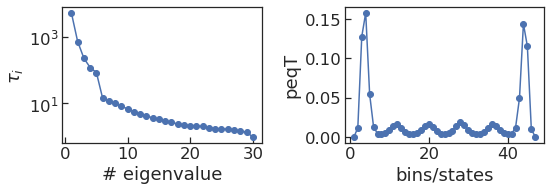

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT,'-o')
ax[0].set_xlabel('# eigenvalue'), ax[0].set_ylabel(r'$\tau_i$'), ax[0].set_yscale('log')
ax[1].plot(range(1,len(msm_1D.msms[lt].peqT)+1),msm_1D.msms[lt].peqT,'-o')
ax[1].set_xlabel('bins/states'), ax[1].set_ylabel('peqT')
plt.tight_layout()

### Define routines for adaptive sampling

In [11]:
class adaptive_sampling(object):

    def __init__(self, reftraj=None, keys=None):
        
        self.reftraj, self.keys = reftraj, keys
        # initialize other classes
        self.resampler = resampler()
        self.msm = MSM()
        
    
    def guess(self, reftraj, keys, n_runs=10, random_inputs=True, dt=1):
        
        self.reftraj, self.keys = reftraj, keys
        self.n_runs = n_runs
        
        tr = traj.TimeSeries(distraj=reftraj, dt=dt)
        tr.find_keys(), tr.keys.sort()
        state_kv, inputs = {}, []
        n_msm_runs = np.random.choice(range(len(keys)), n_runs)
        print('guess inputs:', n_msm_runs)
        for n in n_msm_runs:
            if n not in state_kv.keys():
                gen_dict_state([tr], keys, n, state_kv)
            try:
                frame, which_tr = random.choice(state_kv[n])
                inputs.append([frame, keys[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        self.resampler.state_kv = state_kv
        self.resampler.inputs = inputs
        if not random_inputs:
            inputs = []
            [inputs.append([0,0]) for x in range(n_runs)]
            self.resampler.inputs = inputs
        
    
    def run(self, n_runs=10, n_epochs=10, nsteps=100, \
            lagt=10, scoring='counts', inputs=None, sym=False, dt=1):
        
        if inputs is None and self.resampler.inputs is None:
            self.guess(self.reftraj, self.keys, n_runs=n_runs)
        elif inputs is not None:
            self.n_runs = len(inputs)
            self.resampler.inputs = inputs
            self.resampler.state_kv = {}
        
        self.msmepoch, self.inpepoch, trajfiles, n = [], [], {}, 0
        self.resampler.reftraj = self.reftraj
        
        self.chis = []
        while True:
            trajfiles[n] = self.resampler.resampler(self.reftraj, nsteps)
            n += 1
            if n > n_epochs: break
            self.msm.build_msm(trajfiles, lagt, sym, dt)
            self.msmepoch.append(self.msm.msm)
            self.chis.append(self.chi2(self.msm.msm.count))
            self.resampler.scorer(self.msm.trs, self.msm.msm, self.n_runs, scoring, sym)
            self.inpepoch.append(self.resampler.inputs)
            
    def chi2(self, counts):
        chi = 0.0
        for i in range(len(counts)):
            for j in range(i):
                chi += (counts[i,j]-counts[j,i])*(counts[i,j]-counts[j,i])
        return chi

In [12]:
class resampler(object):
    
    def __init__(self, inputs=None, reftraj=None):
        
        self.inputs = inputs
        self.reftraj = reftraj
        self.state_kv = {}
    
    def resampler(self, reftraj, nsteps):
        
        trajfiles = []
        for inp in self.inputs:
            #print(nsteps,inp)
            data = reftraj[inp[0]:inp[0]+nsteps]
            trajfiles.append(data)

        return trajfiles
    
    
    def scorer(self, trs, mmsm, n_runs, scoring, sym):
    
        if scoring == "counts":
            states = counts(mmsm)
            #states = states.real
        elif scoring == "populations":
            states = populs(mmsm)
            #states = states.real
        elif scoring == "non_detailed_balance":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = non_detbal(mmsm)
        elif scoring == "flux":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = flux_inbalance(mmsm)
        else:
            sys.exit(" Please select one correct scoring.")
       
        #print(states),print(len(mmsm.count[:,0]))
        #print(len(mmsm.keep_states),'states:',mmsm.keep_states)
        #print(len(mmsm.keys),'keys:',mmsm.keys)
        self.inputs = self.gen_input(states, trs, mmsm.keys, mmsm.keep_states, n_runs, scoring)


    def gen_input(self, states, trs, keys, keep_states, n_runs, scoring):

        print('gen_input states:',states)
        if scoring == 'populations':
            n_msm_runs = np.random.choice(range(len(keep_states)), n_runs, p=states)
            aux = keep_states
        else:
            n_msm_runs = np.random.choice(range(len(keys)), n_runs, p=states)
            aux = keys

        tr = traj.TimeSeries(distraj=self.reftraj)
        tr.find_keys(), tr.keys.sort()
        #state_kv, inputs = {}, []
        inputs = []
        for n in n_msm_runs:
            if n not in self.state_kv.keys():
                #gen_dict_state(trs, aux, n, state_kv)
                gen_dict_state([tr], aux, n, self.state_kv)
            try:
                frame, which_tr = random.choice(self.state_kv[n])
                # 'n' stands for the index corresponding to a label
                inputs.append([frame, aux[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        return inputs

In [13]:
def counts(mmsm):
    p = [(0.5/np.sum(mmsm.count[x, :]) + 0.5/np.sum(mmsm.count[:, x])) \
        if (np.sum(mmsm.count[x, x]) != 0) \
        else 0                        \
        for x in range(len(mmsm.keys))]
    if np.sum(p) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return p/np.sum(p)

def populs(mmsm):
    #p = np.nan_to_num(1./mmsm.peqT, nan=0.0)
    p = [1./mmsm.peqT[i] if np.isreal(mmsm.peqT[i]) and \
         not np.isnan(mmsm.peqT[i]) else 0.0 for i in range(len(mmsm.keep_states))]
    #print('before /sum(p):',p)
    return p/np.sum(p)

def non_detbal(mmsm):
    total = mmsm.count + np.transpose(mmsm.count)
    nondb = abs(mmsm.count - np.transpose(mmsm.count))/total
    nondb = np.sum(np.nan_to_num(nondb, nan=0.0), axis=1)
    states = [nondb[i] for i in range(len(mmsm.keys))]
    return states/np.sum(states)

def flux_inbalance(mmsm):
    flux = [(abs(np.sum(mmsm.count[x,:]) - np.sum(mmsm.count[:,x]))/\
    (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:]))) \
    if (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:])) >= 1
    else 0 \
    for x in range(len(mmsm.keys))]
    #this is done by above abs: flux += np.min(flux)
    if np.sum(flux) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return flux/np.sum(flux)

In [14]:
def gen_dict_state(trs, keys, s, state_kv):
    state_kv[s] = []
    n = 0
    for t in trs:
        n +=1
        try:
            ivals = list_duplicates_of(t.distraj, keys[s])
            for i in ivals:
                state_kv[s].append([i, n-1])
        except KeyError:
            pass

In [15]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [16]:
class MSM(object):
    
    def __init__(self, trs=None, msm=None):
        
        self.trs, self.msm = trs, msm
    

    def build_msm(self, trajfiles, lagt, sym, dt):
    
        trs = []
        for epoch in trajfiles.values():
            for data in epoch:
                tr = traj.TimeSeries(distraj=data, dt=dt)
                tr.find_keys(), tr.keys.sort()
                trs.append(tr)
    
        # Invoke SuperMSM to collect keys from all trajectories
        smsm = msm.SuperMSM(trs, sym=sym)
        mymsm = msm.MSM(data=trs, keys=smsm.keys, lagt=lagt, sym=sym)
        mymsm.do_count()
        mymsm.do_trans(evecs=True)
        
        self.trs, self.msm = trs, mymsm

In [17]:
def relative_entropy(MSMp,matq,printmat=False):
    # MSMp for reference, MSMq for test
    # see Bowman et al. PNAS 2010
    entropy = 0.0
    mat = np.zeros((len(MSMp.keep_keys), len(MSMp.keep_keys)))
    for i in MSMp.keep_keys:
        for j in MSMp.keep_keys:
            ip, jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            if MSMp.trans[ip,jp] and matq[ip,jp]:
                aux = np.log(MSMp.trans[ip,jp]/matq[ip,jp])
                mat[ip,jp] = MSMp.peqT[ip]*MSMp.trans[ip,jp]*aux
            else:
                mat[ip,jp] = 0.
    entropy = np.sum(mat[mat!=0])
    if printmat: return entropy, mat
    return entropy

In [18]:
#len(msm_1D.msms[lt].count[0,:])

In [19]:
def pseudo(MSMp,MSMq,tr,count=False):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    #mat = MSMp.count
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
                        keep_states=MSMp.keep_states, count=mat, normalize=False)
    if count: return mat, trans
    return trans

In [20]:
def sortkeys(MSMp,MSMq,tr, evecs=True):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    #mat = MSMp.count
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
                keep_states=MSMp.keep_states, count=mat, normalize=False)
    if evecs is False: return trans
    
    #rvecsT, lvecsT = msm.calc_eigsT(evecs=True)
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = trans, MSMp.keep_states
    tauT, peqT, rvecsT, lvecsT = \
                auxmsm.calc_eigsT(evecs=True)
    return trans, rvecsT

## Adaptive sampling vs. Plain MD

Any adaptive sampling algorithm should improve molecular dynamics calculations with the same amount of cumulative simulation data, so below we compare both of them. Plots similar to the ones used by Hruska et al. JCTC 2020 are employed.

In [44]:
len(distraj.distraj)

1000000

In [45]:
aux = {}
n_runs, n_epochs = 30, 10
for nts in np.arange(2000,2100,500):
    aux[nts] = []
    for i in range(10):
        test = adaptive_sampling()
        test.guess(x[:-1:50], msm_1D.msms[lt].keys, \
                   n_runs=n_runs, random_inputs=True, dt=1)
        test.run(nsteps=nts, lagt=lt, scoring='non_detailed_balance',\
                n_epochs=n_epochs, sym=False, n_runs=n_runs, dt=1)
        aux[nts].append(test.msmepoch)

guess inputs: [ 3  3 29 14 36  4 26 20 18 12  0 45 15  7 41 31  5 43 35 29 20 13  9 43
 29 17  0 25 19 34]
     # states: 46
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
ionix count matrix: [[  30  241  261 ...    0    0    0]
 [ 260 2801 3140 ...    0    0    3]
 [ 278 3123 3974 ...    0    0    0]
 ...
 [   0    0    0 ...   14    0    0]
 [   0    0    0 ...    0  390    0]
 [   0    1    0 ...    0    0    0]]
gen_input states: [0.01015395 0.00676409 0.00533709 0.01565003 0.00931751 0.0183509
 0.01760637 0.03542565 0.04056852 0.02591762 0.01967798 0.012544
 0.01627957 0.0256642  0.0272232  0.02351201 0.02976341 0.03587575
 0.02386224 0.02079407 0.0149833  0.01115222 0.02189885 0.01463705
 0.02978363 0.02659038 0.02230264 0.00874239 0.02717184 0.02837528
 0.03176141 0.03830012 0.04182842 0.0202605  0.02376853 0.02088432
 0.03308682 0.03

     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  225  1849  2156 ...     0     0     0]
 [ 1933 19706 23294 ...     0    11     0]
 [ 2129 23430 28487 ...     0     7     0]
 ...
 [    0     0     0 ...  3893     0     0]
 [    2     7     3 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
gen_input states: [0.01685451 0.00635485 0.01738876 0.01697378 0.00869843 0.01635105
 0.01699305 0.02949627 0.0246467  0.02054242 0.0187282  0.02612362
 0.01458126 0.0086368  0.01578758 0.02229916 0.03362181 0.03389301
 0.01640207 0.01329333 0.02712683 0.02224329 0.03044565 0.0215059
 0.02339712 0.02503149 0.02349374 0.020745   0.02734338 0.02980274
 0.04042407 0.02434112 0.03237844 0.01849204 0.03213859 0.02323702
 0.03210679 0.03337882 0.0105097  0.01773834 0.02054853 0.01726889
 0.00849117 0.

gen_input states: [0.00980064 0.01016662 0.02422132 0.01454077 0.01467587 0.00998639
 0.01187753 0.01555355 0.02725443 0.03164007 0.0176193  0.01956554
 0.01993521 0.01676999 0.02670211 0.03009527 0.03071109 0.02535023
 0.01589867 0.02016062 0.0215769  0.01442501 0.02915803 0.02611866
 0.03173553 0.02844782 0.02180985 0.03853676 0.02999277 0.02067081
 0.01820322 0.01721153 0.01260793 0.02402127 0.0271338  0.00633509
 0.01026905 0.02544392 0.03507609 0.02113719 0.02007654 0.03002244
 0.02427424 0.02152368 0.01887722 0.02419089 0.00859852]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[ 117  191  267 ...    0    0    0]
 [ 161  278  768 ...    0    0    0]
 [ 289  730 2912 ...    0    0    0]
 ...
 [   0    0    0 ...  364  298    0]
 [   0    0    0 ...  254  365    0]
 [   0    0    0 ...    0    0

gen_input states: [0.02295185 0.02883012 0.04273515 0.02093289 0.03123674 0.02754268
 0.03419642 0.03198153 0.03241198 0.02200078 0.01903389 0.01788483
 0.03068364 0.02628004 0.01891156 0.01622463 0.00933743 0.01777458
 0.01252757 0.01938665 0.02701725 0.02020492 0.01645214 0.03609281
 0.01708764 0.01828539 0.01722387 0.02794361 0.01206414 0.01065433
 0.01176139 0.01860497 0.02535598 0.02484102 0.02024728 0.02407196
 0.02251441 0.0109764  0.02036853 0.0228485  0.02081035 0.02756004
 0.01230736 0.0107417  0.01412261 0.01891515 0.00806131]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  321   222   144 ...     0     0     0]
 [  220   179   165 ...     0     0     0]
 [  164   168   217 ...     0     0     0]
 ...
 [    0     0     0 ... 24876  8382     7]
 [    0     0     0 ...  8251  3119     1]


gen_input states: [0.01849311 0.00522802 0.0141991  0.01311304 0.02303595 0.01819588
 0.01158753 0.01470997 0.01167545 0.02717167 0.02354144 0.01315142
 0.02482869 0.03177451 0.04392476 0.02016055 0.02620086 0.01440458
 0.01769197 0.01446709 0.02898133 0.02367253 0.02531856 0.02454475
 0.01377397 0.02037849 0.03205524 0.01974798 0.02432787 0.02027322
 0.01969383 0.02867955 0.02986816 0.0322007  0.02534416 0.03208636
 0.01777138 0.01432298 0.01176519 0.02271177 0.01606862 0.02628733
 0.04058186 0.01182513 0.02445066 0.01831556 0.00739724]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[   0    0    2 ...    0    0    0]
 [   0   95  875 ...    0    0    0]
 [   6  866 8788 ...    0    0    0]
 ...
 [   0    0    0 ...  347  205    0]
 [   0    0    0 ...  211  121    0]
 [   0    0    0 ...    0    0

gen_input states: [0.03015578 0.0213184  0.03631638 0.03016881 0.02107833 0.0218263
 0.0223014  0.01548151 0.00719808 0.01822478 0.01317497 0.0023354
 0.01448621 0.01845138 0.0086421  0.02015378 0.01300714 0.02343305
 0.02183023 0.02483773 0.02795856 0.03155649 0.02054702 0.02630611
 0.01484207 0.02983844 0.02460885 0.03275686 0.02339915 0.01731132
 0.02218498 0.02608726 0.02321974 0.02980989 0.01952729 0.01260708
 0.01481328 0.03294677 0.0282871  0.00961475 0.02320811 0.0239729
 0.01355615 0.02807527 0.03108345 0.01372967 0.01372967]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[389 467 358 ... 187   0   0]
 [449 593 502 ... 214   0   0]
 [287 519 509 ... 128   0   0]
 ...
 [206 217 123 ... 137   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
gen_input states: [0.02663361 0

     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[1770 1993 1456 ... 1141    0    0]
 [2038 2895 2385 ... 1006    0    0]
 [1378 2502 2495 ...  624    0    0]
 ...
 [1065  982  536 ...  795    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
gen_input states: [0.01850103 0.03327038 0.01105681 0.00791183 0.01535309 0.02288292
 0.01256524 0.01690891 0.02265174 0.01087435 0.00615392 0.01813818
 0.01585327 0.01629489 0.01507819 0.02000429 0.01055374 0.01041085
 0.01871977 0.01789892 0.01612829 0.01615733 0.03692282 0.02945282
 0.01707181 0.03962407 0.01745098 0.02013075 0.03461855 0.03026572
 0.0295171  0.01988082 0.0170335  0.03872615 0.02400811 0.03986429
 0.03434481 0.02134591 0.02707951 0.01912881 0.01141056 0.01981774
 0.01896877 0.04498102 0.02334172 0.01186716 0.01

     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  148  1325  1498 ...     0     0     0]
 [ 1293 13938 16683 ...     0     0     8]
 [ 1563 16702 20220 ...     0     0     1]
 ...
 [    0     0     0 ...   460   369     0]
 [    0     0     0 ...   408   405     0]
 [    1     3     4 ...     0     0     0]]
gen_input states: [0.01435097 0.01699969 0.00906764 0.01980575 0.01787843 0.0159682
 0.02069793 0.0202586  0.01972054 0.02526027 0.0241029  0.02376332
 0.01640136 0.039121   0.01111831 0.0266133  0.03606647 0.02368047
 0.01961045 0.01697269 0.01960703 0.02469325 0.02699338 0.01650305
 0.02419128 0.01701684 0.01388121 0.01071225 0.00398611 0.02491532
 0.02669407 0.02657353 0.01642539 0.01909062 0.02329459 0.01923056
 0.01931014 0.02700492 0.03799078 0.02120819 0.01542306 0.0304895
 0.02094931 0.0

gen_input states: [0.02523033 0.00856535 0.02645934 0.01470287 0.01577328 0.02847153
 0.02478486 0.01156263 0.01552032 0.00923182 0.01992507 0.01957207
 0.00359929 0.01723877 0.01514768 0.0206477  0.02440976 0.03765923
 0.02690528 0.01661898 0.01756196 0.01324203 0.01969633 0.02388591
 0.02951617 0.0339745  0.01820974 0.02410455 0.01362726 0.00666626
 0.02700286 0.0321249  0.04432456 0.01866834 0.02258017 0.01813131
 0.01058769 0.01803824 0.02114145 0.02122695 0.01887064 0.02332027
 0.03892243 0.03330471 0.02233784 0.02214154 0.02476524]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[ 759  955  805 ...    0    0    0]
 [1051 1483 1672 ...    0    0    0]
 [ 853 1696 2428 ...    0    0    0]
 ...
 [   0    0    0 ... 1586 1733    0]
 [   0    0    0 ... 1640 2162    0]
 [   0    0    0 ...    0    0

     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[1251  702  353 ...    5    4    0]
 [ 689  511  335 ...    0    0    0]
 [ 377  312  238 ...    0    0    0]
 ...
 [   2    0    0 ...  393  218    0]
 [   6    0    0 ...  192  155    0]
 [   0    0    0 ...    0    0    0]]
gen_input states: [0.01962803 0.01056777 0.01842764 0.02267622 0.03223926 0.03237826
 0.02173821 0.01920014 0.02465343 0.02731776 0.03661446 0.01414684
 0.02594726 0.0147301  0.02612514 0.040461   0.03144791 0.02072557
 0.0266518  0.0277959  0.01744375 0.01043978 0.02944685 0.0264318
 0.0090228  0.00935812 0.01185068 0.01156944 0.00974758 0.01597096
 0.01563741 0.01909389 0.02164438 0.01213952 0.01887406 0.03085415
 0.0229603  0.03724581 0.03028354 0.01951822 0.01326664 0.02576431
 0.01993618 0.03350366 0.0187698  0.01263398 0.003

gen_input states: [0.01509974 0.01605686 0.02540287 0.00893208 0.01913424 0.01557545
 0.02655306 0.03163387 0.00609891 0.01611847 0.02083443 0.02521832
 0.01635129 0.02517929 0.02549163 0.03083506 0.02050595 0.02936521
 0.02140536 0.02423642 0.02350892 0.02815897 0.02891983 0.02694133
 0.03250882 0.00638346 0.0192008  0.02904659 0.00772715 0.00897879
 0.02287465 0.02630212 0.01301976 0.04066697 0.03885333 0.0181682
 0.01601589 0.01861656 0.01773732 0.02115291 0.02053899 0.03893074
 0.02407397 0.01633127 0.01463689 0.00973048 0.01094679]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  76  611  673 ...    0    0    0]
 [ 596 6501 7708 ...    0    4    0]
 [ 695 7692 9529 ...    0    3    0]
 ...
 [   0    0    0 ...  479    0    0]
 [   0    2    2 ...    0    0    0]
 [   0    0    0 ...    0    0 

gen_input states: [0.01187124 0.02054327 0.0126781  0.0173427  0.01733065 0.02466293
 0.02474776 0.01270776 0.02270333 0.05021601 0.03132314 0.02301484
 0.0374709  0.00964597 0.00384091 0.03344421 0.02962094 0.03769694
 0.0353155  0.01774103 0.02249006 0.02194666 0.01021166 0.02362874
 0.01951085 0.01659101 0.01809313 0.02944216 0.01820939 0.02422965
 0.01559486 0.02320406 0.01798714 0.02014957 0.01458634 0.05172931
 0.03124974 0.02684999 0.0174675  0.01356948 0.01300277 0.01475412
 0.01607442 0.01845627 0.010086   0.01696699]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  48  394  486 ...    0    0    0]
 [ 392 4351 5269 ...    0    0    0]
 [ 486 5242 6234 ...    0    0    0]
 ...
 [   0    0    0 ...   23    0    0]
 [   0    0    0 ...    0   70    0]
 [   0    0    0 ...    0    0    0]]
gen

gen_input states: [0.00651317 0.01211413 0.02333464 0.02028564 0.01913853 0.01397771
 0.02135461 0.02118407 0.02591273 0.02115126 0.04202808 0.03644617
 0.02059361 0.01846402 0.02131367 0.01059006 0.02783328 0.03476519
 0.02487389 0.03694956 0.01350596 0.02409345 0.01526884 0.02333563
 0.01747878 0.02297716 0.03222322 0.02802955 0.00980976 0.02316886
 0.02040335 0.02602305 0.02561127 0.0291097  0.03002091 0.02268523
 0.02377208 0.01714248 0.01670269 0.01571635 0.01450217 0.02778272
 0.01235948 0.00833826 0.01277375 0.01854019 0.00980111]
     # states: 47
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[  208  1853  2257 ...     0     0     0]
 [ 1855 20036 24362 ...     0     0     0]
 [ 2180 24467 29553 ...     0     0     0]
 ...
 [    0     0     0 ...   195     0     1]
 [    0     0     0 ...     0   350     0]


In [46]:
def msmpop(MSMp,MSMq,tr):
    mat = np.zeros((len(MSMp.trans[:,0]),len(MSMp.trans[:,0])))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keep_keys:
        for j in MSMq.keep_keys:
            iq,jq = MSMq.keep_keys.index(i), MSMq.keep_keys.index(j)
            ip,jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            mat[ip,jp] = mat[ip,jp] + MSMq.trans[iq,jq]
    
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = mat, MSMp.keep_states
    tauT, peqT = auxmsm.calc_eigsT()
    
    score = 0.0
    for p,pq in zip(MSMp.peqT,peqT):
        #score += np.absolute(pq - p)
        score += ((pq - p)*(pq - p))/p
    
    return score #*100.

In [47]:
matent, mattim = np.zeros((n_epochs,len(np.arange(2000,2100,500))), float), np.zeros((n_epochs,len(np.arange(2000,2100,500))), float)
matmpop, matpop = np.zeros((n_epochs,len(np.arange(2000,2100,500))), float), np.zeros((n_epochs,len(np.arange(2000,2100,500))), float)
ent = []
pop, mpop, tim = [], [], []
for ints,nts in enumerate(np.arange(2000,2100,500)):
    epochs = []
    for i in range(n_epochs):
        epochs.append([row[i] for row in aux[nts]])
    for nep,msmepo in enumerate(epochs):
        auxent, auxtim, auxmpop, auxpop = [], [], [], []
        for i in range(10):
            # metric 1
            qmat = pseudo(msm_1D.msms[lt], msmepo[i], distraj)
            auxent.append(relative_entropy(msm_1D.msms[lt], qmat))
            # metric 2
            score = 0.0
            for tref,t in zip(msm_1D.msms[lt].tauT[:5],msmepo[i].tauT[:5]):
                score += ((t-tref)*(t-tref))/tref
                #score += np.absolute(t - tref)
            auxtim.append(score)
            # metric 3
            auxpop.append(np.absolute(float(len(msmepo[i].keep_states))/ \
                    float(len(msm_1D.msms[lt].keep_states)))*100.)
            # metric 4
            auxmpop.append(msmpop(msm_1D.msms[lt], msmepo[i], distraj))

        ent.append([nep*n_runs+n_runs, nts, np.mean(auxent)])
        matent[nep, ints] = np.mean(auxent)
        
        tim.append([nep*n_runs+n_runs, nts, np.mean(auxtim)])
        mattim[nep, ints] = np.mean(auxtim)
        
        mpop.append([nep*n_runs+n_runs, nts, np.mean(auxmpop)])
        matmpop[nep, ints] = np.mean(auxmpop)
        
        pop.append([nep*n_runs+n_runs, nts, np.mean(auxpop)])
        matpop[nep, ints] = np.mean(auxpop)

In [48]:
plottime = [row[0]*row[1] for row in pop]
plotexp, plotmpop, plottim  = [row[2] for row in pop], [row[2] for row in mpop], [row[2] for row in tim]
print(plottime)

[60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000]


In [49]:
ref = x[:-1:50] #x[:-1:50]
len(distraj.distraj), len(ref)

(1000000, 1000000)

In [51]:
# Build fractions of PLAIN MD
lt = 10
rmats = {}
ldata = np.arange(2000,2100,500)
for plains in ldata:
    rmats[plains] = []
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        plaindistraj = traj.TimeSeries(distraj=ref[:alltime], dt=1) #ref[:ldata], dt=10
        plaindistraj.find_keys(), plaindistraj.keys.sort()
        plainmsm = msm.SuperMSM([plaindistraj], sym=True)
        plainmsm.do_msm(lt)
        plainaux = plainmsm.msms[lt]
    #aux.count = aux.count + 1./float(len(plaindistraj.distraj))
        plainaux.do_trans(evecs=False)
        rmats[plains].append(plainaux)

     # states: 47
 symmetrizing
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[   0    0    6 ...    0    0    0]
 [   0   78  833 ...    0    0    0]
 [   6  833 8798 ...    0    0    0]
 ...
 [   0    0    0 ... 2204  186    0]
 [   0    0    0 ...  186   22    0]
 [   0    0    0 ...    0    0    0]]
     # states: 47
 symmetrizing
ionix keep_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
ionix count matrix: [[    0     0     8 ...     0     0     0]
 [    0   104  1107 ...     0     0     0]
 [    8  1107 11894 ...     0     0     0]
 ...
 [    0     0     0 ...  9084   808     1]
 [    0     0     0 ...   808    66     0]
 [    0     0     0 ...     1     0     0]]
     # s

In [52]:
rmats.keys(), aux.keys()

(dict_keys([2000]), dict_keys([2000]))

In [54]:
mdtim, mdmpop, mdexp = {}, {}, {}
ldata = np.arange(2000,2100,500)
for plains in ldata:
    mdtim[plains], mdexp[plains], mdmpop[plains] = [], [], []

    for epo in range(n_epochs):
        mdexp[plains].append(np.absolute(float(len(rmats[plains][epo].keep_states))/ \
            float(len(msm_1D.msms[lt].keep_states)))*100.)
        mdmpop[plains].append(msmpop(msm_1D.msms[lt], rmats[plains][epo], distraj))        
        score = 0.0
        for tref,t in zip(msm_1D.msms[lt].tauT[:5],rmats[plains][epo].tauT[:5]):
            score += ((t-tref)*(t-tref))/tref #score += np.absolute(t - tref)
        mdtim[plains].append(score)

In [55]:
# check if KEYS coincide
listnow = [plottime[i*n_epochs:i*n_epochs+n_epochs] for i in range(1)]
for plains in [2000]:
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        print(alltime)
print(listnow)

60000
120000
180000
240000
300000
360000
420000
480000
540000
600000
[[60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000]]


Plot % of explored states

(Text(0.5, 0, 'total steps'), Text(0, 0.5, '% explored pop NONDB'))

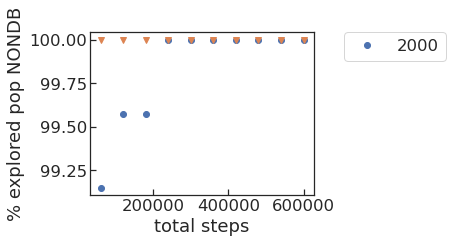

In [58]:
fig, ax = plt.subplots(1,figsize=(4,3),sharey=True )
for i in range(1):
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotexp[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdexp[list(aux.keys())[i]],'v')
ax.set_xlabel('total steps'),ax.set_ylabel('% explored pop NONDB')

Plot difference in MSM populations

(Text(0.5, 0, 'total steps'), Text(0, 0.5, 'MSM pops - NONDB'))

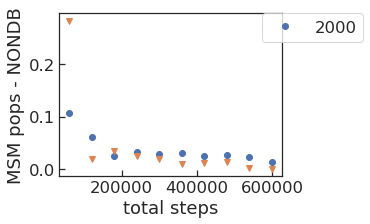

In [59]:
fig, ax = plt.subplots(1,figsize=(4,3),sharey=True )
for i in range(1):
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotmpop[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax.legend(bbox_to_anchor=(1.4, 1.05))
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdmpop[list(aux.keys())[i]],'v')
ax.set_xlabel('total steps'),ax.set_ylabel('MSM pops - NONDB')

Plot difference in relaxation times

(Text(0.5, 0, 'total steps'), Text(0, 0.5, 'diff in relax times-NONDB'))

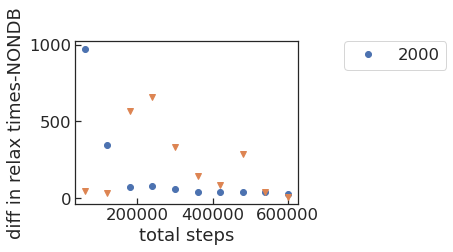

In [60]:
fig, ax = plt.subplots(1,figsize=(4,3),sharey=True )
for i in range(1):
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plottim[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax.legend(bbox_to_anchor=(1.7, 1.05))
    ax.plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdtim[list(aux.keys())[i]],'v')
ax.set_xlabel('total steps'),ax.set_ylabel('diff in relax times-NONDB')